# word2vec 개선 1

## Embedding 계층 구현

In [1]:
import numpy as np

W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
# import cupy as cp

# class Embedding:
#     def __init__(self, W):
#         self.params = [W]
#         self.grads = [np.zeros_like(W)]
#         self.index= None
        
#     def forward(self, idx):
#         W, = self.params
#         idx = idx.astype(cp.int_)
#         self.idx = idx
#         out = W[self.idx]

#         # out = W[self.idx]
#         return out
    
#     def backward(self, dout):
#         dW, = self.grads
#         dW[...] = 0
#         np.add.at(dW, self.idx, dout)
    
#         return None

In [6]:
import cupyx
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            cupyx.scatter_add(dW, self.idx, dout)
        else:
            np.add.at(dW, self.idx, dout)
        return None

# word2vec 개선 2

## 다중 분류에서 이진 분류로 구현

In [7]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W*h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

## 네거티브 샘플링의 샘플링 기법

In [8]:
import numpy as np

np.random.choice(10)

4

In [9]:
np.random.choice(10)

5

In [10]:
words = ['you', 'say', 'goodbye', 'i', 'hello', '.']

In [11]:
np.random.choice(words)

'i'

In [12]:
np.random.choice(words, size=5)

array(['.', 'you', 'say', '.', 'you'], dtype='<U7')

In [13]:
np.random.choice(words, size=5, replace=False)

array(['.', 'i', 'hello', 'you', 'goodbye'], dtype='<U7')

In [14]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, size=5, p=p)

array(['say', '.', 'i', 'you', 'say'], dtype='<U7')

In [15]:
p = [0.7, 0.29, 0.01]

In [16]:
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
new_p

array([0.64196878, 0.33150408, 0.02652714])

In [17]:
new_p = np.power(p, 0.25)
new_p /= np.sum(new_p)
new_p

array([0.46554957, 0.37350027, 0.16095016])

In [18]:
import collections

counts = collections.Counter()

counts['apple'] = 1
counts

Counter({'apple': 1})

In [19]:
counts['orange'] = 2
counts

Counter({'apple': 1, 'orange': 2})

In [20]:
counts['apple'] += 3
counts

Counter({'apple': 4, 'orange': 2})

In [21]:
import collections

# Negative Sampling 클래스 구현
# chap04/negative_sampling_layer.py
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                # p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample

In [22]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2
GPU = False

In [23]:
sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[1, 3],
       [2, 1],
       [2, 4]], dtype=int32)

## 네거티브 샘플링 구현

In [24]:
# chap04/negative_sampling_layer.py
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

## 개선판 Word2Vec 학습

### CBOW 모델 구현

In [25]:
# chap04/cbow.py
import sys
sys.path.append('..')
from common.np import *

In [26]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [27]:

class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

### CBOW 모델 학습 코드

In [28]:
# chap04/train.py
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from common.layers import SigmoidWithLoss
from dataset import ptb

In [29]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

In [30]:
# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 101 / 9295 | 시간 12[s] | 손실 40.48
| 에폭 1 |  반복 201 / 9295 | 시간 25[s] | 손실 34.71
| 에폭 1 |  반복 301 / 9295 | 시간 37[s] | 손실 31.50
| 에폭 1 |  반복 401 / 9295 | 시간 49[s] | 손실 29.93
| 에폭 1 |  반복 501 / 9295 | 시간 62[s] | 손실 29.08
| 에폭 1 |  반복 601 / 9295 | 시간 74[s] | 손실 28.36
| 에폭 1 |  반복 701 / 9295 | 시간 87[s] | 손실 27.91
| 에폭 1 |  반복 801 / 9295 | 시간 99[s] | 손실 27.47
| 에폭 1 |  반복 901 / 9295 | 시간 112[s] | 손실 27.07
| 에폭 1 |  반복 1001 / 9295 | 시간 124[s] | 손실 26.79
| 에폭 1 |  반복 1101 / 9295 | 시간 137[s] | 손실 26.58
| 에폭 1 |  반복 1201 / 9295 | 시간 149[s] | 손실 26.37
| 에폭 1 |  반복 1301 / 9295 | 시간 162[s] | 손실 26.21
| 에폭 1 |  반복 1401 / 9295 | 시간 174[s] | 손실 26.06
| 에폭 1 |  반복 1501 / 9295 | 시간 187[s] | 손실 25.95
| 에폭 1 |  반복 1601 / 9295 | 시간 199[s] | 손실 25.82
| 에폭 1 |  반복 1701 / 9295 | 시간 212[s] | 손실 25.71
| 에폭 1 |  반복 1801 / 9295 | 시간 224[s] | 손실 25.66
| 에폭 1 |  반복 1901 / 9295 | 시간 237[s] | 손실 25.51
| 에폭 1 |  반복 2001 / 9295 | 시간 249[s] | 손실 25.54
| 에폭 1 |  반복 2

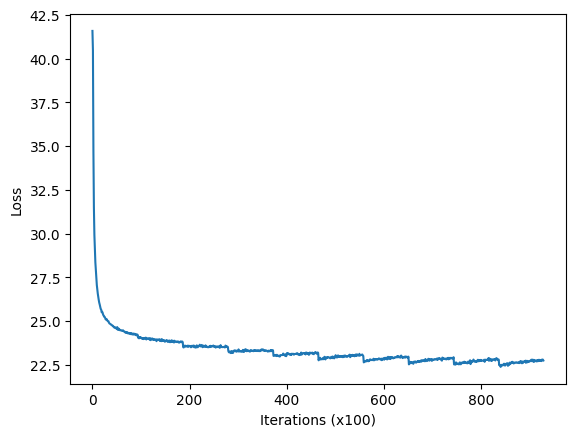

In [31]:
# 학습 시작
trainer.fit(contexts.get(), target.get(), max_epoch, batch_size, eval_interval=100)
trainer.plot()

In [32]:
import pickle
pkl_file = './output/SkipGram_100_5_song.pkl'

with open(pkl_file, 'wb') as f:
    params = pickle.dump(trainer, f)